In [1]:
# Transfer Learning(전이학습) 
# Kaggle COVID19 Detection - COVID19 감염 예측 이미지 분류
# COVID 19 Radiography 은 감염 예측 이미지 분류
# - COVID(코로나), Viral Pneumonia(바이러스성 폐럼), Lung Opacity(폐 음영 - 폐렴, 폐암, 간질성 폐 질환 등 다양한 원인), Normal(정상) 
# 발견하고 예측하기 위해서 Kaggle의 공개 데이터로서 총 21,165개 Chest X-Ray 이미지 데이터

In [3]:
# 1) import, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets # 다양한 사전 학습 모델을 포함한 모듈
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os, shutil, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [ ]:
# 2) 데이터 다운로드 - Kaggle Face Mask Dataset
# 데이터 폴더 존재시 삭제
if os.path.exists('./data/covid_19_radiography'):
    shutil.rmtree('./data/covid_19_radiography')
    print('./data/covid_19_radiography is removed')
    
if os.path.exists('./data/covid_19_radiography_split'):
    shutil.rmtree('./data/covid_19_radiography_split')
    print('./data/covid_19_radiography_split is removed')

./data/COVID-19_Radiography is removed
./data/emotion_detection_split is removed


In [5]:
# 3) 압축풀기 - os에 맞추어 압축 풀고, 폴더 구성
if not os.path.exists('./data/COVID-19_Radiography.zip'):
    raise FileNotFoundError('압축 파일이 존재하지 않습니다. ./data/COVID-19_Radiography.zip 경로를 확인하세요.')
else:
    print('압축 파일 존재함. ./data/COVID-19_Radiography.zip')
    with zipfile.ZipFile('./data/COVID-19_Radiography.zip', 'r') as target_file:
        target_file.extractall('./data/covid_19_radiography')
        print('압축 해제 완료. ./data/COVID-19_Radiography.zip')

압축 파일 존재함. ./data/COVID-19_Radiography.zip
압축 해제 완료. ./data/COVID-19_Radiography.zip


In [7]:
# 4) 데이터 경로 설정
ROOT_DIR = './data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'covid_19_radiography_split')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [ ]:
# 5) 데이터셋 분할 작업 - Covid 19 Radiography 데이터셋, train:valid:test = 7:1.5:1.5
# 원본 데이터 폴더 구조
SOURCE_DIR = './data/covid_19_radiography/COVID-19_Radiography_Dataset'  # 원본 데이터셋 폴더 경로
TARGET_DIR = './data/covid_19_radiography_split'  # 분할된 데이터셋을 저장할 폴더 경로
SPLITS = ['train', 'validation', 'test'] # 데이터셋 분할 폴더 이름
SPLIT_RATIOS = {'train':0.7, 'validation':0.15, 'test':0.15} # 데이터셋 분할 비율
EMOTIONS = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'] # 분류 클래스 목록

# 타겟 폴더 생성, 예시)./data/covid_19_radiography_split/train/COVID, Lung_Opacity, Normal, Viral Pneumonia
for split in SPLITS: # train, validation, test
    for emotion in EMOTIONS: # COVID, Lung_Opacity, Normal, Viral Pneumonia
        os.makedirs(os.path.join(TARGET_DIR, split, emotion), exist_ok=True) # 폴더 생성, exist_ok=True 옵션으로 이미 존재해도 에러 발생하지 않음

# 각 감정 폴더에서 이미지 분할
for emotion in EMOTIONS:
    emotion_dir = os.path.join(SOURCE_DIR, emotion) # 원본 폴더 경로, ./data/covid_19_radiography/COVID-19_Radiography_Dataset/COVID, Lung_Opacity, Normal, Viral Pneumonia
    emotion_dir_images = os.path.join(emotion_dir, 'images') # 별도 이미지 폴더 있음
    images = [ f for f in os.listdir(emotion_dir_images) if os.path.isfile(os.path.join(emotion_dir_images, f)) ] # 폴더 내 모든 이미지 파일 리스트
    random.shuffle(images) # 이미지 파일 리스트 무작위 섞기

    total = len(images) # 이미지 파일 총 개수
    train_count = int(total * SPLIT_RATIOS['train']) # train 데이터셋 끝 인덱스
    val_count = int(total * SPLIT_RATIOS['validation']) # validation 데이터셋 끝 인덱스
    test_count = total - train_count - val_count # test 데이터셋 개수

    split_images = {
        'train': images[:train_count], # 처음부터 train_count 까지
        'validation': images[train_count:train_count + val_count], # train_count 부터 train_count + val_count 까지
        'test': images[train_count + val_count:] # train_count + val_count 부터 끝까지
    }
    # print(emotion, '->', {k: len(v) for k, v in split_images.items()}) # 각 분류별 분할된 이미지 개수 출력

    # 이미지 파일 복사
    for split in SPLITS: # train, validation, test
        for img in split_images[split]: # 각 분할된 이미지 파일
            src_path = os.path.join(emotion_dir_images, img) # 원본 이미지 파일 경로
            dst_path = os.path.join(TARGET_DIR, split, emotion, img) # 복사될 이미지 파일 경로
            shutil.copy2(src_path, dst_path) # 이미지 파일 복사, 메타데이터도 함께 복사
print('데이터셋 분할 및 복사 완료')

데이터셋 분할 및 복사 완료


In [25]:
dataset_path = os.path.join(TARGET_DIR, 'train')
for emotion in EMOTIONS:
    images = os.listdir(os.path.join(dataset_path, emotion))
    total = len(images)
    print('train:', emotion, total)

dataset_path = os.path.join(TARGET_DIR, 'validation')
for emotion in EMOTIONS:
    images = os.listdir(os.path.join(dataset_path, emotion))
    total = len(images)
    print('validation:', emotion, total)

dataset_path = os.path.join(TARGET_DIR, 'test')
for emotion in EMOTIONS:
    images = os.listdir(os.path.join(dataset_path, emotion))
    total = len(images)
    print('test:', emotion, total)

train: COVID 2531
train: Lung_Opacity 4208
train: Normal 7134
train: Viral Pneumonia 941
validation: COVID 542
validation: Lung_Opacity 901
validation: Normal 1528
validation: Viral Pneumonia 201
test: COVID 543
test: Lung_Opacity 903
test: Normal 1530
test: Viral Pneumonia 203


In [ ]:
# # 5) 전체 데이터셋 통합 및 재분할 함수 정의
# # 현재 데이터가 train, test로 나뉘어 있으니, 두 폴더를 먼저 통합
# # 전체 데이터를 클래스별로 7:1.5:1.5 비율로 train, validation, test로 다시 분할
# def restructure_dataset(train_dir, test_dir, output_root, ratio=(0.7, 0.15, 0.15)):
#     class_names = os.listdir(train_dir) # train 폴더의 클래스 목록 ['glioma', 'meningioma', 'notumor', 'pituitary']
    
#     for class_name in class_names:
#         # 통합된 클래스별 이미지 목록
#         train_class_path = os.path.join(train_dir, class_name)
#         test_class_path = os.path.join(test_dir, class_name)

#         all_images = []
#         if os.path.exists(train_class_path):
#             all_images += [os.path.join(train_class_path, f) for f in os.listdir(train_class_path)]
#         if os.path.exists(test_class_path):
#             all_images += [os.path.join(test_class_path, f) for f in os.listdir(test_class_path)]

#         random.shuffle(all_images)

#         total = len(all_images)
#         train_end = int(ratio[0] * total)
#         val_end = train_end + int(ratio[1] * total)

#         splits = {
#             'train': all_images[:train_end],
#             'validation': all_images[train_end:val_end],
#             'test': all_images[val_end:]
#         }

#         for split_name, split_files in splits.items():
#             dst_dir = os.path.join(output_root, split_name, class_name)
#             os.makedirs(dst_dir, exist_ok=True)
#             for src_path in split_files:
#                 filename = os.path.basename(src_path)
#                 dst_path = os.path.join(dst_dir, filename)
#                 shutil.copy(src_path, dst_path)

#         print(f"{class_name}: total={total}, train={len(splits['train'])}, val={len(splits['validation'])}, test={len(splits['test'])}")

# # 데이터셋 재구성 실행
# restructure_dataset(
#     train_dir='./data/emotion_detection/train',
#     test_dir='./data/emotion_detection/test',
#     output_root='./data/emotion_detection_split',
#     ratio=(0.7, 0.15, 0.15)
# )


angry: total=4953, train=3467, val=742, test=744
disgusted: total=547, train=382, val=82, test=83
fearful: total=5121, train=3584, val=768, test=769
happy: total=8989, train=6292, val=1348, test=1349
neutral: total=6198, train=4338, val=929, test=931
sad: total=6077, train=4253, val=911, test=913
surprised: total=4002, train=2801, val=600, test=601


In [26]:
# 6) 데이터 전처리 설정
# train
train_config = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),  # 회전 강도 완화
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# validation
validation_config = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 흑백 이미지를 3채널로 확장
    transforms.Resize( (224,224) ), # 이미지 사이즈
    transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
])
# test
test_config = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 흑백 이미지를 3채널로 확장
    transforms.Resize( (224,224) ), # 이미지 사이즈
    transforms.ToTensor(), # 이미지 픽셀값 0~255 -> 0~1 사이의 값의로 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 이미지 정규화
])

In [27]:
# 7) 데이터셋 생성- ImageFolder 사용 → 폴더 구조 기반으로 자동 라벨링
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_ROOT_DIR, transform=train_config) # train dataset
validation_dataset = datasets.ImageFolder(root=VALIDATION_DATA_ROOT_DIR, transform=validation_config) # validation dataset
test_dataset = datasets.ImageFolder(root=TEST_DATA_ROOT_DIR, transform=test_config) # test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].


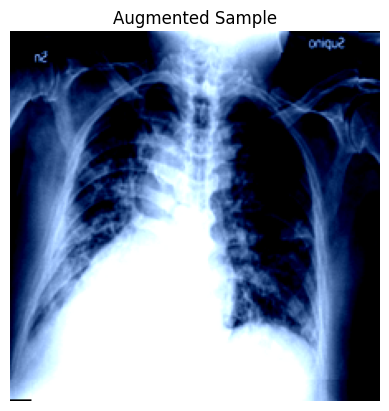

In [28]:
import matplotlib.pyplot as plt

sample = train_dataset[0][0]  # 이미지 텐서
plt.imshow(sample.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt.title("Augmented Sample")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


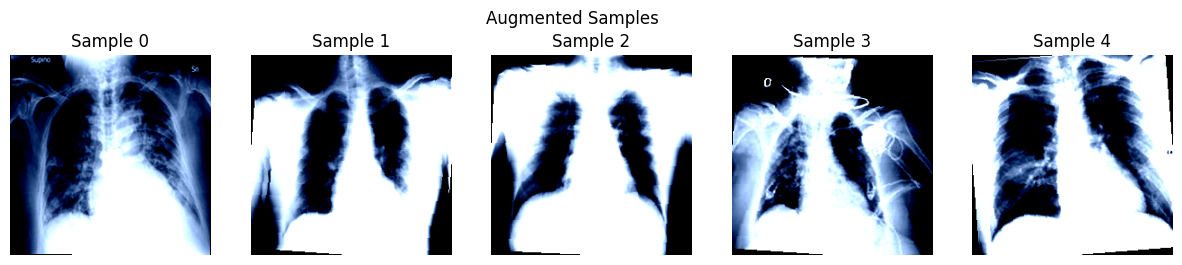

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    sample = train_dataset[i][0]
    axes[i].imshow(sample.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f"Sample {i}")
plt.suptitle("Augmented Samples")
plt.show()

In [30]:
from collections import Counter

# train_dataset.targets는 클래스 인덱스 리스트
class_counts = Counter(train_dataset.targets)
print(class_counts)

Counter({2: 7134, 1: 4208, 0: 2531, 3: 941})


In [36]:
# WeightedRandomSampler 적용 코드
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# 클래스별 샘플 수
class_counts = dict(Counter(train_dataset.targets))
num_samples = len(train_dataset)

# 클래스별 가중치 계산 (샘플 수의 역수)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플에 대한 가중치 부여
sample_weights = [class_weights[label] for label in train_dataset.targets]
sample_weights = torch.DoubleTensor(sample_weights)

# 샘플러 정의
sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)

# 데이터로더에 적용
# train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)


In [38]:
# 8) 데이터로더 설정
import multiprocessing
num_workers = multiprocessing.cpu_count() // 2 # // 정수 나눗셈 연산자
BATCH_SIZE = 32
# num_workers=4 - 데이터를 로딩할 때 사용할 CPU 프로세스 수, 일반적으로 CPU 코어 수 / 2 또는 4~8 추천, pin_memory=True - GPU 사용 시 데이터를 고정된 메모리로 올려서 전송 속도 향상, - x.to(DEVICE) 할 때 더 빠르게 복사됨
# train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=num_workers, pin_memory=True)
validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}


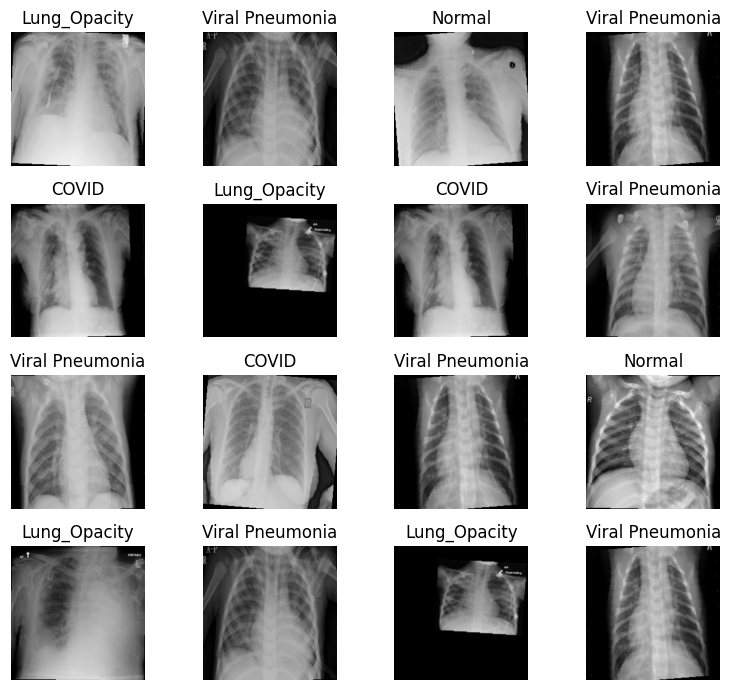

In [39]:
# 9) 데이터 확인
images, labels = next(iter(train_dataset_loader)) # - train_dataset_loader로 변경, 1개 배치 추출
print(images.shape, labels.shape)

labels_map = { v : k for k, v in train_dataset.class_to_idx.items() } # - train_dataset.class_to_idx 사용
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # - torch.randint()는 0부터 high - 1 사이의 정수를 생성
    # - len(images)는 현재 배치에 포함된 이미지 수예요. 예를 들어 BATCH_SIZE = 32이면 len(images)는 32
    # - size = (1,) 생성할 정수의 **개수와 형태(shape)**를 지정, (1,)은 1개의 정수를 담은 1차원 텐서를 의미, 예시: tensor([17]) 결과
    sample_idx = torch.randint(len(images), size=(1, )).item() # 0~31 사이의 정수 중 하나를 랜덤하게 생성
    img, label = images[sample_idx], labels[sample_idx].item() # - 이미지와 라벨 추출

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C) 순서 변경
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# from collections import Counter
# print(Counter([label for _, label in train_dataset]))

In [ ]:
# # 10) Transfer Learning Model - ResNet
# class TransferLearningModel(nn.Module):
#     def __init__(self, base_model, feature_extractor, num_classes=7):
#         super().__init__()
#         # ViT는 encoder.layer.N 형태로 여러 Transformer 블록을 포함하고 있으며 예를 들어 아래처럼 일부만 동결
#         # - 예시) encoder.layer.0~3까지 freeze → 일반적인 특징 유지
#         # - 예시) encoder.layer.4~11은 fine-tune → 데이터셋에 맞게 조정
#         if(feature_extractor):
#             for name, param in base_model.named_parameters():
#                 # if 'encoder.layer.0' in name or 'encoder.layer.1' in name: # Vision Transformer 기반 구조 
#                 if 'layer1' in name or 'layer2' in name or 'conv1' in name: # ResNet 기반 구조
#                     param.requires_grad = False  # 초기 레이어 동결
#                 else:
#                     param.requires_grad = True   # 나머지 레이어는 학습
                    
#         # base_model.heads = nn.Sequential(
#         #     nn.Linear(base_model.heads[0].in_features, 256), # pretrained_model.heads를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
#         #     nn.ReLU(), # 활성화 함수
#         #     nn.Dropout(p=0.5), # 드롭아웃
#         #     nn.Linear(256, 64), # 은닉층
#         #     nn.ReLU(), 
#         #     nn.Dropout(p=0.5),
#         #     nn.Linear(64, len(train_dataset.classes)) # 최종 출력층 - 4가지 face mask 분류(classification)
#         # )
#         base_model.fc = nn.Sequential(
#             nn.Linear(base_model.fc.in_features, 256), # pretrained_model.fc를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
#             nn.ReLU(), # 활성화 함수
#             nn.Dropout(p=0.5), # 드롭아웃
#             nn.Linear(256, 64), # 은닉층
#             nn.ReLU(), 
#             nn.Dropout(p=0.5),
#             nn.Linear(64, num_classes) # 최종 출력층 - 7가지 사람 표정 분류(classification)
#         )
#         self.model = base_model
    
#     def forward(self, x):
#         x = self.model(x) # - 사전학습된 모델의 순전파 메서드 호출
#         return x

# # 전체 레이어 이름 확인(디버깅용)
# # for name, param in base_model.named_parameters():s
# #     print(name, param.requires_grad)

In [40]:
# 10) Transfer Learning Model - ResNet
class TransferLearningModel(nn.Module):
    def __init__(self, base_model, feature_extractor, num_classes=7):
        super().__init__()
        # ViT는 encoder.layer.N 형태로 여러 Transformer 블록을 포함하고 있으며 예를 들어 아래처럼 일부만 동결
        # - 예시) encoder.layer.0~3까지 freeze → 일반적인 특징 유지
        # - 예시) encoder.layer.4~11은 fine-tune → 데이터셋에 맞게 조정
        if(feature_extractor):
            for name, param in base_model.named_parameters():
                # if 'encoder.layer.0' in name or 'encoder.layer.1' in name: # Vision Transformer 기반 구조 
                if 'layer1' in name or 'layer2' in name or 'conv1' in name: # ResNet 기반 구조
                    param.requires_grad = False  # 초기 레이어 동결
                else:
                    param.requires_grad = True   # 나머지 레이어는 학습
                    
        # base_model.heads = nn.Sequential(
        #     nn.Linear(base_model.heads[0].in_features, 256), # pretrained_model.heads를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
        #     nn.ReLU(), # 활성화 함수
        #     nn.Dropout(p=0.5), # 드롭아웃
        #     nn.Linear(256, 64), # 은닉층
        #     nn.ReLU(), 
        #     nn.Dropout(p=0.5),
        #     nn.Linear(64, len(train_dataset.classes)) # 최종 출력층 - 4가지 face mask 분류(classification)
        # )
        base_model.fc = nn.Sequential(
            nn.Linear(base_model.fc.in_features, 256), # pretrained_model.fc를 새로 정의 → 기존 MLP Head를 커스터마이징하여 2개 클래스 분류에 맞춤
            nn.ReLU(), # 활성화 함수
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.3), # 드롭아웃
            nn.Linear(256, 64), # 은닉층
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.3),
            nn.Linear(64, num_classes) # 최종 출력층 - 7가지 사람 표정 분류(classification)
        )
        self.model = base_model
    
    def forward(self, x):
        x = self.model(x) # - 사전학습된 모델의 순전파 메서드 호출
        return x

# 전체 레이어 이름 확인(디버깅용)
# for name, param in base_model.named_parameters():s
#     print(name, param.requires_grad)

In [41]:
# 11) EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='./models/model_transfer_learning_covid19_detection.pt'):
        self.patience = patience          # 개선되지 않아도 기다릴 epoch 수
        self.verbose = verbose            # 개선 시 출력 여부
        self.counter = 0                  # 개선되지 않은 epoch 수
        self.best_score = None            # 최고 성능 점수
        self.early_stop = False           # 중단 여부
        self.val_loss_min = float('inf')  # 최소 validation loss
        self.delta = delta                # 개선 최소 차이
        self.path = path                  # 모델 저장 경로

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [42]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

# 클래스 인덱스 리스트
targets = train_dataset.targets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(targets),
    y=targets
)

# 텐서로 변환 후 GPU로 이동
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

In [43]:
# 12) 모델, 손실함수, 옵티마이저 객체생성 및 하이퍼라마미터 설정
# base_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT) # Vision Transformer(ViT) 모델을 ImageNet 사전학습 가중치로 불러오는 코드
base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # ResNet 모델을 사전학습 가중치로 불러옴.
feature_extractor = True # - feature_extractor = False → fine-tuning 모드로 전체 모델 학습
num_classes = 4
model = TransferLearningModel(base_model=base_model, feature_extractor=feature_extractor, num_classes=num_classes).to(DEVICE) # - model 객체 생성
# loss_function = nn.CrossEntropyLoss() # loss function
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor) # Balanced Loss 적용 코드
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer

print(model) # - 모델 구조 출력

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\AI/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 47.0MB/s]


TransferLearningModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [44]:
# 13) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0 # train loss 합
    train_correct = 0 # train 맞춘 개수
    train_total = 0 # train 전체 개수
    total_train_batch = len(dataloader) # 전체 배치 개수
    for images, labels in dataloader: # dataloader에서 배치 단위로 이미지와 라벨 추출        
        x_train = images.to(DEVICE) # GPU로 데이터 전송
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train) # 모델 예측
        loss = loss_function(outputs, y_train) # 손실함수 계산

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item() # 오차 누적
        train_total += y_train.size(0) # 배치 내 샘플 개수 누적
        train_correct += (torch.argmax(outputs, dim=1) == y_train).sum().item() # - argmax로 예측값과 실제값 비교 후 맞춘 개수 누적
        
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [45]:
# 14) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)
        for images, labels in dataloader:            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1) == y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [46]:
# 15) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)
        for images, labels in dataloader:            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == y_test).sum().item()
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)
        return test_avg_loss, test_avg_accuracy


In [47]:
# 16) Confusion Matrix(혼동행렬) 시각화 함수
def confusion_matrix_plot(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    cm = confusion_matrix(all_labels, all_preds) # 혼동행렬(Confusion Matrix) 계산
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[labels_map[i] for i in range(len(labels_map))]) # - display_labels에 클래스 이름 전달
    plt.figure(figsize=(8, 6)) # - 그래프 크기 설정
    disp.plot(cmap=plt.cm.Blues) # - 블루 계열의 컬러맵 사용
    plt.xticks(rotation=45) # x축 라벨 45도 회전
    plt.title('Confusion Matrix') # - 타이틀 추가
    plt.show()

In [48]:
# 17) Classification Report 함수
def classification_report_plt(dataloader, model):
    model.eval() # 추론모드
    all_labels = []
    all_preds = []
    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test) # 모델 추론
            _, preds = torch.max(outputs, 1) # 모델 예측값 추출

            all_labels.extend(y_test.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
            all_preds.extend(preds.cpu().numpy()) # - CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
    
    target_names = list(labels_map.values()) # - 클래스 이름 리스트 생성
    report = classification_report(all_labels, all_preds, target_names=target_names, digits=4) # - 분류 리포트 생성, digits=4로 소수점 4자리까지 출력 → 정밀한 비교 가능

    print(report) # - 분류 리포트 출력

In [50]:
# 18) Model 학습 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
start_time = datetime.now()
early_stopping = EarlyStopping(patience=3, verbose=True)
EPOCHS = 10 # cpu 사용시 에폭 3배이상 낮게 설정

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader, model=model, loss_function=loss_function, optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader, model=model, loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # early stopping
    early_stopping(val_loss=val_avg_loss, model=model)
    
    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

Validation loss decreased (inf → 0.317311). Saving model...
epoch :  01 train loss =  0.143779 , train acc =  90.731740 val loss =  0.317311 , val acc =  88.083228
Validation loss decreased (0.317311 → 0.253310). Saving model...
epoch :  02 train loss =  0.103555 , train acc =  92.864858 val loss =  0.253310 , val acc =  91.519546
Validation loss decreased (0.253310 → 0.216913). Saving model...
epoch :  03 train loss =  0.086110 , train acc =  94.106926 val loss =  0.216913 , val acc =  92.812106
EarlyStopping counter: 1 out of 3
epoch :  04 train loss =  0.075234 , train acc =  94.808964 val loss =  0.237256 , val acc =  92.150063
Validation loss decreased (0.216913 → 0.174079). Saving model...
epoch :  05 train loss =  0.066137 , train acc =  95.004725 val loss =  0.174079 , val acc =  93.789407
EarlyStopping counter: 1 out of 3
epoch :  06 train loss =  0.055409 , train acc =  95.862022 val loss =  0.189621 , val acc =  93.221942
EarlyStopping counter: 2 out of 3
epoch :  07 train l

In [51]:
# 19) 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  94.0547341931425 , loss =  0.17541310171451185


(0.17541310171451185, 94.0547341931425)

<Figure size 800x600 with 0 Axes>

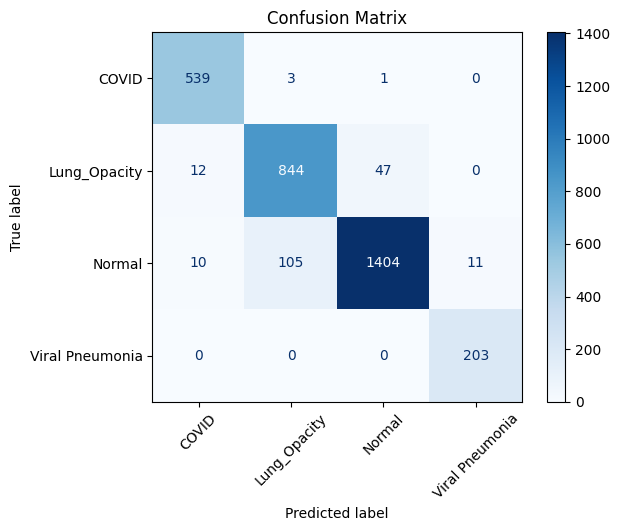

In [52]:
# 20) Confusion Matrix(혼동행렬) 시각화
confusion_matrix_plot(dataloader=test_dataset_loader, model=model)

In [53]:
# 21) clssification report 출력
classification_report_plt(dataloader=test_dataset_loader, model=model)

                 precision    recall  f1-score   support

          COVID     0.9608    0.9926    0.9764       543
   Lung_Opacity     0.8866    0.9347    0.9100       903
         Normal     0.9669    0.9176    0.9416      1530
Viral Pneumonia     0.9486    1.0000    0.9736       203

       accuracy                         0.9405      3179
      macro avg     0.9407    0.9612    0.9504      3179
   weighted avg     0.9419    0.9405    0.9406      3179



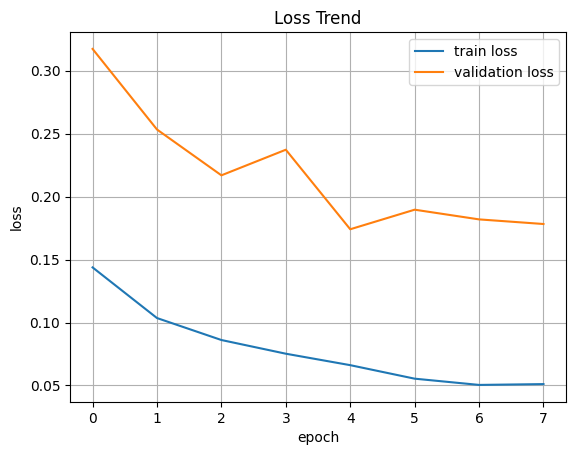

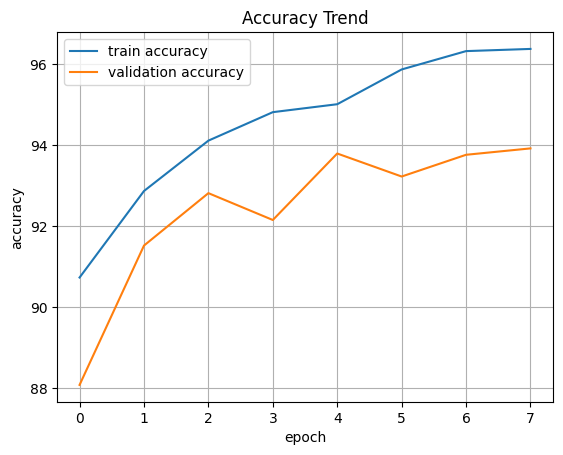

In [54]:
# 22) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [55]:
# 23) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_transfer_learning_covid19_detection.pt')

In [56]:
# 24) 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_images, test_labels = next(iter(test_image_loader)) # 1개 배치 추출

x_test = test_images.to(DEVICE) # - GPU로 데이터 이동
y_test = test_labels.to(DEVICE)

outputs = model(x_test) # 모델 추론
_, preds = torch.max(outputs, 1) # 모델 예측값 추출

{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}


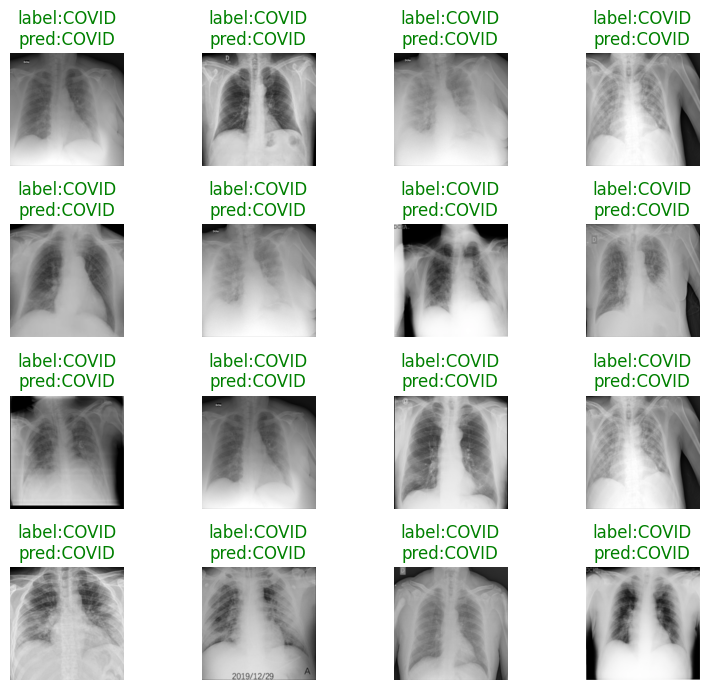

In [59]:
# 25) 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    img = img.clamp(0, 1) # 0~1 사이의 값으로 클램핑

    correct = (label == pred) # 정답 여부
    title_color = 'green' if correct else 'red' # 정답이면 녹색, 오답이면 빨간색
    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred], color=title_color) # - 정답이면 녹색, 오답이면 빨간색 타이틀 출력
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()